In [1]:
import pandas
from pandas_datareader import data
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.kde import gaussian_kde
from numpy import linspace
import scipy.stats as stats

# Download the data and calculate the returns

In [3]:
VBLTX_prices = data.DataReader('vbltx',  'yahoo', datetime.date(2005, 9, 1), datetime.date(2010,9,30))["Adj Close"]
FMAGX_prices = data.DataReader('fmagx',  'yahoo', datetime.date(2005, 9, 1), datetime.date(2010,9,30))["Adj Close"]
SBUX_prices = data.DataReader('sbux',  'yahoo', datetime.date(2005, 9, 1), datetime.date(2010,9,30))["Adj Close"]

VBLTX_prices = VBLTX_prices.resample('1M').last()
FMAGX_prices = FMAGX_prices.resample('1M').last()
SBUX_prices = SBUX_prices.resample('1M').last()

VBLTX_prices.index = list(map(lambda dt: datetime.date(dt.year, dt.month, 1), VBLTX_prices.index))
FMAGX_prices.index = list(map(lambda dt: datetime.date(dt.year, dt.month, 1), FMAGX_prices.index))
SBUX_prices.index = list(map(lambda dt: datetime.date(dt.year, dt.month, 1), SBUX_prices.index))

all_prices = pandas.concat([VBLTX_prices, FMAGX_prices, SBUX_prices], join='outer', axis=1)
all_prices.columns = ["VBLTX", "FMAGX", "SBUX"]


# The standard error of the variances

Consider the constant expected return model (CER):

$R_{it} = \mu_{i}+\epsilon_{it},$

$t=1,…,T$

$\epsilon_{it} \sim \ iid \ N(0,\sigma^2_i)$

$cov(\epsilon_{it},\epsilon_{jt})=\sigma_{ij},$

where Rit denotes the continuously compounded return on asset i

Estimate the standard errors in order to get $\hat{SE}(\hat{\sigma^2_i}).$

The formula is given by:

$\hat{SE}(\hat{σ^2_i})=\hat{σ^2_i}/(\sqrt{T/2}).$

In [5]:
all_returns = np.log(all_prices).diff()[1:]

n_obs = all_returns.shape[0]

sigma2hat_vals = all_returns.var()
se_sigma2hat = sigma2hat_vals/np.sqrt(n_obs/2)

se_sigma2hat

VBLTX    0.000158
FMAGX    0.000823
SBUX     0.001960
dtype: float64

# Estimate the standard error of the correlation parameter

$\hat{SE}(\hat{\rho_{ij}})=(1 \text{-} \hat{\rho_{ij}^2})/\sqrt{T}.$

In [6]:
cor_matrix = all_returns.corr()
cor_matrix = np.asarray(cor_matrix)

rhohat_vals = pandas.DataFrame(cor_matrix[np.triu_indices(3, 1)])
rhohat_vals.index = ["VBLTX,FMAGX","VBLTX,SBUX","FMAGX,SBUX"]

se_rhohat = (1-rhohat_vals**2)/np.sqrt(all_returns.shape[0])
se_rhohat.columns = ['Rho hat']
se_rhohat

,Rho hat
"VBLTX,FMAGX",0.124565
"VBLTX,SBUX",0.126729
"FMAGX,SBUX",0.080578


# Hypothesis test for the mean

Test for each $\mu_i$ ($i$= VBLTX, FMAGX and SBUX):

$H_0:\mu_i=0\ vs.\ H_1:\mu_i\neq0,$

using a 5% significance level.

In [8]:
one_sample = stats.ttest_1samp(all_returns["VBLTX"],0.0)

print("The t-statistic is %.3f and the p-value is %.3f." % one_sample)

The t-statistic is 1.554 and the p-value is 0.126.


# Hypothesis test for the correlation

Test for each $\rho_{ij}$ ($ij$= "VBLTX, FMAGX", "VBLTX, SBUX" and "FMAGX, SBUX"):

$H_0:\rho_{ij}=0\ vs.\ H_1:\rho_{ij}\neq0,$

using a 5% significance level

In [10]:
corr = stats.pearsonr(all_returns["VBLTX"], all_returns["FMAGX"])  #may be wrong?

z = np.arctanh(corr[0])

sigma = (1/((len(all_returns.index)-3)**0.5))

cint = z + np.array([-1, 1]) * sigma * stats.norm.ppf((1+0.95)/2)

cintVal = np.tanh(cint)

print("correlation coefficient: %.3f and the p-value is %.3f" % corr)
print("95 percent confidence interval: \n%.5f %.5f" % (cintVal[0], cintVal[1]))

correlation coefficient: 0.187 and the p-value is 0.152
95 percent confidence interval: 
-0.06983 0.42129


In [11]:
corr = stats.pearsonr(all_returns["VBLTX"], all_returns["SBUX"])  #may be wrong?

z = np.arctanh(corr[0])

sigma = (1/((len(all_returns.index)-3)**0.5))

cint = z + np.array([-1, 1]) * sigma * stats.norm.ppf((1+0.95)/2)

cintVal = np.tanh(cint)

print("correlation coefficient: %.3f and the p-value is %.3f" % corr)
print("95 percent confidence interval: \n%.5f %.5f" % (cintVal[0], cintVal[1]))

correlation coefficient: -0.136 and the p-value is 0.302
95 percent confidence interval: 
-0.37649 0.12263


# Normality of the asset returns
test the null hypothesis:

$H_0:r_{it} \sim normal\ vs. \ H_1:r_{it} \sim not\ normal$

using a 5% significance level, with $i=VBLTX$.

In [13]:
result = stats.jarque_bera(all_returns["VBLTX"])

print("X-squared = %.3f, p-value = %f" % result)

X-squared = 22.258, p-value = 0.000015


In [14]:
result = stats.jarque_bera(all_returns["FMAGX"])

print("X-squared = %.3f, p-value = %f" % result)

X-squared = 26.001, p-value = 0.000002


# Bootstrapping

In [15]:
def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : array_like
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if n == None:
        n = len(X)
        
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    return X_resample

mean_list = []

for i in range (1, 1000):
    X_sample = bootstrap_resample(all_returns['VBLTX'])
    mean_list.append(np.mean(X_sample))
    
bias = np.sum(mean_list - np.mean(all_returns['VBLTX']))/len(mean_list)
std_error = np.std(mean_list)/np.sqrt(len(mean_list))

print("Original mean %.6f" % np.mean(all_returns['VBLTX']))
print("Boostrap mean %.6f bias: %.6f std. error %.6f" % (np.mean(mean_list), bias, std_error))


Original mean 0.005897
Boostrap mean 0.005914 bias: 0.000017 std. error 0.000118


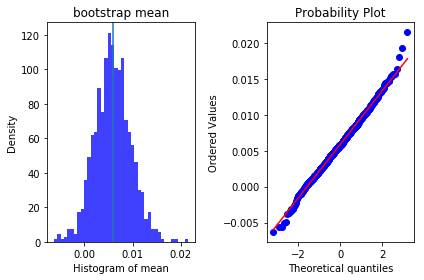

In [16]:
plt.close('all')
fig, ((ax1), (ax2)) = plt.subplots(nrows=1, ncols=2)
# the histogram of the data

n, bins, patches = ax1.hist(mean_list, 40, normed=1, facecolor='blue', alpha=0.75, )
ax1.axvline(x=np.mean(all_returns['VBLTX']))
ax1.set_xlabel('Histogram of mean')
ax1.set_ylabel('Density')
ax1.set_title('bootstrap mean')

stats.probplot(mean_list, dist="norm", plot=ax2)

plt.tight_layout()
plt.show()